# Testing if passing z* iteratively would lead to better depth estimate 

Making changes in the forward function


Changes/Result:
1. Do filtering on angle matrix rather than Gram matrix/SDA computation correct - verified
2. Use angle matrix for SDA output/Training reduced SDA from 0.7 to 0.02
3. Add non-linearity between initial z layers/


3 Oct:
1. Test inversion by looking into gradients/activation per feedfwd layer for z* estimation [fc0,1,2]


In [277]:
import torch
import torch.nn as nn
from torch.nn import functional as fn
from torch.autograd import Variable
import matplotlib
import torch.nn.functional as F 
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import plotly 
#plotly.tools.set_credentials_file(username='mishra40', api_key='nuOxcWWzZSBv7dFtO4F3')
import chart_studio.plotly as py
import plotly.graph_objs as go
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

__Python VERSION: 3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]
__pyTorch VERSION: 1.1.0
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2015 NVIDIA Corporation
Built on Tue_Aug_11_14:27:32_CDT_2015
Cuda compilation tools, release 7.5, V7.5.17
__CUDNN VERSION: 7501
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


## Utils

In [278]:

def num_edges(n):
    return int(n*(n-1)/2)

def restructure_conn_mat(hverts, vverts, conn):
    conn_mat=conn
    new_conn_mat = torch.Tensor()
    nverts = hverts+vverts
    tot = int((vverts*(vverts-1))/2)
    nv_seq = np.arange(nverts)[::-1]
    vv_seq = np.arange(vverts)[::-1]
    # convert vverts conn_mat to nverts conn_mat
    for i,v in enumerate(vv_seq):
            if (v==0):
                break
            pad = min(nverts-vverts, nverts-i-1)
            n1 = max(vverts-i-1,0)
            n2 = tot - n1
            #print("i,pad,n1,n2,tot,conn_mat -- ",i,pad,n1,n2,tot,conn_mat)
            if (tot > 1): 
                c1,c2 = torch.Tensor.split(conn_mat,[n1,n2],dim=2)
            else:
                c1 = conn_mat #torch.Tensor.clone(conn_mat)
                c2 = torch.Tensor(conn_mat) #torch.Tensor.zero_(conn_mat)
            if (tot==0):
                pad = pad-1
            m = nn.ConstantPad2d((0,pad,0,0),1)
            c1 = m(c1)
            new_conn_mat = torch.cat((new_conn_mat,c1), dim=2)
            #print("adding hidden verts in new_conn_mat -- ",new_conn_mat)
            conn_mat = c2
            tot = c2.size()[-1]
            #print("new conn mat shape: ", new_conn_mat.shape)
    # number of elements to skip from vverts        
    n = vv_seq[0]        
    # create rest of vverts conn_mat
    for i,v in enumerate(nv_seq[n:]):
        if (v==0):
            break  
        c1 = torch.ones(1,3,v)
        new_conn_mat = torch.cat((new_conn_mat,c1), dim=2)
        
    #new_conn_mat = expand_conn_mat(maxverts,nverts,new_conn_mat)    
    return new_conn_mat

def expand_conn_mat(nverts, vverts, conn):
    conn_mat=conn
    new_conn_mat = torch.Tensor()
    tot = int((vverts*(vverts-1))/2)
    nv_seq = np.arange(nverts)[::-1]
    vv_seq = np.arange(vverts)[::-1]
    # convert vverts conn_mat to nverts conn_mat
    for i,v in enumerate(vv_seq):
            if (v==0):
                break
            pad = min(nverts-vverts, nverts-i-1)
            n1 = max(vverts-i-1,0)
            n2 = tot - n1
            #print("i,pad,n1,n2,tot,conn_mat -- ",i,pad,n1,n2,tot,conn_mat)
            if (tot > 1): 
                c1,c2 = torch.Tensor.split(conn_mat,[n1,n2],dim=2)
            else:
                c1 = conn_mat #torch.Tensor.clone(conn_mat)
                c2 = torch.Tensor(conn_mat) #torch.Tensor.zero_(conn_mat)
            if (tot==0):
                pad = pad-1
            m = nn.ZeroPad2d((0,pad,0,0))
            c1 = m(c1)
            new_conn_mat = torch.cat((new_conn_mat,c1), dim=2)
            #print("new_conn_mat -- ",new_conn_mat)
            conn_mat = c2
            tot = c2.size()[-1]
    # number of elements to skip from vverts        
    n = vv_seq[0]        
    # create rest of vverts conn_mat
    for i,v in enumerate(nv_seq[n:]):
        if (v==0):
            break  
        c1 = torch.zeros(1,3,v)
        new_conn_mat = torch.cat((new_conn_mat,c1), dim=2)
    return new_conn_mat



## Network - layers for learning z' from z and mapping SDA from Gram Mat

Still using network within network

In [363]:
# new version
import torch.nn.functional as F 
from functools import reduce

class DepthEstNet(nn.Module):    
    def __init__(self, vertices, nonlinearity = fn.tanh, additional_hidden_wide=0):
        super(DepthEstNet, self).__init__()
        self.vertices = vertices
        input_dim = vertices * 3
        self.edges = int(num_edges(vertices))
        edge_dim = self.edges * 3
        edges = self.edges
        self.conv_edge_vec = nn.ModuleList()
        self.conv_edge_num = vertices-1
        
        self.fc0 = nn.Linear(vertices, vertices)
        #self.conv_edge_vec.append(fc0)
        #torch.nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)

        for i in range(1,vertices):
            m = nn.Conv1d(3, 3, 2, stride=1, dilation=i)
            m.weight = torch.nn.Parameter(torch.from_numpy(np.array(
            [[[1, -1],
             [0, 0],
             [0, 0]],
    
            [[0, 0],
             [1,-1],
             [0,0]],

            [[0,  0],
             [0, 0],
             [1, -1]]], dtype=np.float32)))
            m.bias = torch.nn.Parameter(torch.from_numpy(np.array([0,0,0], dtype=np.float32)))
            m.requires_grad = False
            self.conv_edge_vec.append(m)
        
        for i in range(self.conv_edge_num):
            params = self.conv_edge_vec[i].parameters()
            for p in params:
                p.requires_grad=False        
                
        
#         self.deconv_edge_vec = nn.ModuleList()
#         self.deconv_edge_num = vertices-1
#         for i in range(1,vertices):
#             m = nn.Conv1d(3, 3, 2, stride=1, dilation=vertices-i)
#             m.requires_grad = True
#             self.deconv_edge_vec.append(m)        
        
        
        self.reverse_learn_params = nn.ModuleList()
        fc1 = nn.Linear(vertices, vertices)
        self.reverse_learn_params.append(fc1)
        fc2 = nn.Linear(vertices, vertices)
        self.reverse_learn_params.append(fc2)
        fc3 = nn.Linear(vertices, vertices)
        self.reverse_learn_params.append(fc3)
        
        
#         fc4 = nn.Linear(edges, edges*10)
#         self.reverse_learn_params.append(fc4)
#         fc5 = nn.Linear(edges*10, 1)
#         self.reverse_learn_params.append(fc5)
        
#         fc6 = nn.Linear(edges, edges*10)
#         self.reverse_learn_params.append(fc6)
#         fc7 = nn.Linear(edges*10, vertices*10)
#         self.reverse_learn_params.append(fc7)
#         fc8 = nn.Linear(vertices*10, vertices)
#         self.reverse_learn_params.append(fc8)
        
        self.nonlinearity = nonlinearity
        
#         self.layernorm = nn.LayerNorm(edges)
#         self.cos = nn.CosineSimilarity(dim=0, eps=1e-6)

    def show_grad(self):
        for i in range(self.conv_edge_num):
            y = self.conv_edge_vec[i]
            print("#", i, "conv net grads: ",y.weight.grad,y.bias.grad)
        for y in (self.reverse_learn_params):
            print("other grads: ",y.weight.grad,y.bias.grad)
        
        
    def forward(self, vverts, conn_mat, debug=False, extract_x=False, extract_y=False, extract_z=False):
        
        n,d,vv = vverts.size()
        #print(n,d,v)
    
        #padding for missing verts
        nverts = self.vertices
        pad = nverts - vv
        m = nn.ZeroPad2d((0, pad, 0, 0)) #padding(left,right,top,bottom)
        xyz = m(vverts)
        
        if (debug == True): print("initial xyz", xyz)
            
        x_vec = xyz[:,0,:] 
        y_vec = xyz[:,1,:]
        z_vec = xyz[:,2,:]

        if (debug == True): print("initial z", z_vec)
        
        temp = (self.reverse_learn_params[0](z_vec))
        temp = self.nonlinearity(temp)
        temp = (self.reverse_learn_params[1](temp))
        temp = self.nonlinearity(temp)
        z_vertexs_recovered = self.reverse_learn_params[2](temp)
        
        new_xyz = []
        new_xyz.append(x_vec.squeeze(0))
        new_xyz.append(y_vec.squeeze(0))
        new_xyz.append(z_vertexs_recovered.squeeze(0))
        new_xyz = torch.stack(new_xyz).unsqueeze(0)
        
        if (debug == True): print("new xyz", new_xyz)
        
        n,d,num_v_edge = conn_mat.size()
        #conn_mat = expand_conn_mat(nverts,vv,conn_mat)

        for i in range(self.conv_edge_num):
            y = self.conv_edge_vec[i](new_xyz)
            #y = self.nonlinearity(y)
            #print("#", i, "conv net output: ",y)
            if (i==0):
                output = y
            else:
                output = torch.cat((output,y), dim=2)
    
        if (debug == True): print("Conv output: ", output)         
            
        c_x_vec = output[:,0,:] 
        c_y_vec = output[:,1,:]
        c_z_vec = output[:,2,:]
        
        norm_mat = F.normalize(output, p=2, dim=1)
        
        if (debug == True): print("Normalized output",norm_mat)
        
        gram_mat = [torch.mm(mat.transpose(1,0),mat) for mat in norm_mat[:]]
        gram_mat = torch.stack(gram_mat)
        
        if (debug == True): print("Gram matrix: ",gram_mat)
        
#         filter_mat = [mat for mat in conn_mat[:]] #[torch.mm(mat.transpose(1,0),mat) for mat in conn_mat[:]]
#         filter_mat = torch.stack(filter_mat)
        
        filter_mat = conn_mat[:,0,:].expand(gram_mat.shape[1],gram_mat.shape[2])

        if (debug == True): print("filter matrix: ", filter_mat)
                
        N = self.vertices
        mat_row = []
        for r in range(N-1,0,-1):
            mats = []
            for n in range(r,0,-1):
                #print("n = ",n)
                f = np.ones((n,n), dtype=int)
                for i in range(1,n):
                    f[-i-2::-1,-i] = 0 
                f = f.T&f
                mat = np.copy(f)
                pad = r-n
                for j in range(pad,0,-1):
                    if (j>n):
                        p = np.zeros((1,n), dtype=int)
                    else:
                        p = f[:,-j]
                    mat = np.vstack((mat,p))   
                #print("mat shape: ", mat.shape)
                mats.append(mat)

            mats=np.hstack(mats)

            #print(mats)

            pad = int(N*(N-1)/2) - mats.shape[1] 
            m = nn.ZeroPad2d((pad, 0, 0, 0)) #padding(left,right,top,bottom)

            mats = torch.from_numpy(np.asarray(mats,dtype=np.float32))
            mat_row.append(m(mats))

        mat_row = torch.cat(mat_row)    
    
#         if (debug == True): print("gram * conn", gram_mat*filter_mat)
        
#         gram_mat = gram_mat*filter_mat*mat_row
        
#         if (debug == True): print("gram * conn * mat_row", gram_mat)

        gram_mat = torch.clamp(gram_mat, min=-0.99999, max=0.99999)
        
        if (debug == True): print("gram mat clamped: ", gram_mat)
  
        
#         ang = torch.acos(gram_mat)
        
#         if (debug == True): print("ang",np.rad2deg(ang.detach().numpy()))
            
#         sda = torch.std(ang)
        
#         if (debug == True): print("sda", sda)
            

        ang = torch.acos(gram_mat)*filter_mat*mat_row
        
        if (debug == True): print("filtered ang",np.rad2deg(ang.detach().numpy()))
            
        sda = torch.std(ang)
        
        if (debug == True): print("filtered sda", sda)
    

#         temp = (self.reverse_learn_params[5](c_x_vec))
#         temp = (self.reverse_learn_params[6](temp))
#         vertexs_recovered = (self.reverse_learn_params[7](temp))
#         optimizer = torch.optim.SGD(self.reverse_learn_params.parameters(), lr = 1e-1 , momentum=0.8)
#         criterion = nn.MSELoss()
#         optimizer.zero_grad()
#         if (debug == True): print(" vertexs_recovered diffs:", x_vec - vertexs_recovered)
#         #print(" x[:,0,:]:", x[:,0,:])
#         loss = criterion(vertexs_recovered, x_vec)
#         if (debug == True): print("network reverse loss", loss)
#         loss.backward(retain_graph=True)
#         optimizer.step()
        
        

#         optimizer = torch.optim.SGD(self.reverse_learn_params.parameters(), lr = 1e-1 , momentum=0.8)
#         criterion = nn.MSELoss()
#         optimizer.zero_grad()
#         loss = torch.std(gram_mat) #criterion(gram_mat, torch.Tensor.new_zeros(gram_mat, gram_mat.size()))
#         loss.backward(retain_graph=True)
#         optimizer.step()
                  
            
#         if (extract_z):
#             temp = (self.reverse_learn_params[5](c_z_vec))
#             temp = (self.reverse_learn_params[6](temp))
#             z_vertexs_recovered = (self.reverse_learn_params[7](temp))
            
    
#             temp = (self.reverse_learn_params[5](c_y_vec))
#             temp = (self.reverse_learn_params[6](temp))
#             y_vertexs_recovered = (self.reverse_learn_params[7](temp))
            
    
#             temp = (self.reverse_learn_params[5](c_x_vec))
#             temp = (self.reverse_learn_params[6](temp))
#             x_vertexs_recovered = (self.reverse_learn_params[7](temp))
            
#             return (x_vertexs_recovered, y_vertexs_recovered, z_vertexs_recovered)  
        
#         n,d,e = output.size()            
#         output = F.normalize(output, p=2, dim=1)
#         output = [torch.mm(mat.transpose(1,0),mat) for mat in output[:]]
#         return torch.stack(output)

#         temp = (self.reverse_learn_params[3](gram_mat))
#         sda = (self.reverse_learn_params[4](temp))
        
#         if (debug == True): print("sda", sda)
            
        return sda
    
    def inversion(self, vverts, conn_mat, debug=False):
        output = self.forward(vverts, conn_mat, debug)
        print("network output: ", (output))
        sda_max =  Variable(torch.zeros(1), requires_grad=False)
        criterion = nn.L1Loss()
        loss = criterion(output, sda_max)
        loss.backward()
        print(self.reverse_learn_params[0].weight.grad)
        

In [364]:

nverts = 8
model = DepthEstNet(nverts, nonlinearity=fn.sigmoid, additional_hidden_wide=1)
device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)
model.to(device)



cpu


DepthEstNet(
  (conv_edge_vec): ModuleList(
    (0): Conv1d(3, 3, kernel_size=(2,), stride=(1,))
    (1): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(2,))
    (2): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(3,))
    (3): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(4,))
    (4): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(5,))
    (5): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(6,))
    (6): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(7,))
  )
  (fc0): Linear(in_features=8, out_features=8, bias=True)
  (reverse_learn_params): ModuleList(
    (0): Linear(in_features=8, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=8, bias=True)
  )
)

In [365]:
import torch.utils.data
dataset = torch.utils.data.TensorDataset(train_xyz_obj, train_xy_conn, train_xy_sda)
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
lr, mom, epochs, batch_size = 1e-1 , 0.5, 2 , 5
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=mom)
train_accum=[]
i = 0
criterion = nn.L1Loss()

In [366]:
print(list(model.parameters())[:])

[Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 1., -1.]]]), Parameter containing:
tensor([0., 0., 0.]), Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 1., -1.]]]), Parameter containing:
tensor([0., 0., 0.]), Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 1., -1.]]]), Parameter containing:
tensor([0., 0., 0.]), Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 1., -1.]

## Create Training Set

In [367]:
train_xy_obj = [] #torch.Tensor()
train_xyz_obj = []
train_xy_conn = []
train_xy_deg = [] 
train_xy_ang = []
train_xy_sda = []

objs = []

with open('training/vverts/cube/data.pickle.5.p.1000.objs', 'rb') as f:
    data = pickle.load(f)

for i in range(len(data)):
    if(i%5 > 0):
        continue
    obj = np.asarray(data[i])
    conn = np.asarray(data[i+1]) 
    deg = np.asarray(data[i+2]) 
    angs = np.asarray(data[i+3]) 
    sda = np.asarray(data[i+4]) 
    print("obj: ", obj)
    print("obj shape: ", obj.shape)
    objs.append(np.copy(obj))
    
    print("deg: ", deg)
    deg = torch.from_numpy(np.asarray(deg,dtype=np.float32))
    deg = deg.unsqueeze(0)
    train_xy_deg.append(deg)
    
    print("ang: ", angs)
    angs = torch.from_numpy(np.asarray(angs,dtype=np.float32))
    angs = angs.unsqueeze(0)
    train_xy_ang.append(angs)
    
    
    print("sda: ", sda)
    sda = torch.from_numpy(np.asarray(sda,dtype=np.float32))
    sda = sda.unsqueeze(0)
    train_xy_sda.append(sda)
    
    
    #train_xyz_obj.append(torch.from_numpy(np.asarray(obj,dtype=np.float32)).unsqueeze(0))  
    
    vv = obj.shape[1]
    print("vv: ",vv)
    obj[2,0:vv]=0
    vverts = torch.from_numpy(np.asarray(obj,dtype=np.float32))
    vverts = vverts.unsqueeze(0)
    pad = nverts - vv
    m = nn.ZeroPad2d((0, pad, 0, 0)) #padding(left,right,top,bottom)
    x = m(vverts)
    train_xyz_obj.append(x)   
    
    
    
    conn = torch.from_numpy(np.asarray(conn,dtype=np.float32))
    conn = conn.unsqueeze(0)
    print("conn: ", conn)
    print("conn shape: ", conn.shape)
    conn_mat = restructure_conn_mat(8-vv,vv,conn)
#    print("hidden conn mat: ", conn_mat)
    print("restrcutured conn shape: ", conn_mat.shape)
    conn_mat = expand_conn_mat(nverts,8,conn_mat)
#     print("expanded conn mat: ", conn_mat)  
    print("conn shape: ", conn_mat.shape)
    train_xy_conn.append(conn_mat)


# train_xy_obj = torch.cat(train_xy_obj)
# print(train_xy_obj.shape)

train_xyz_obj = torch.cat(train_xyz_obj)
print(train_xyz_obj.shape)

train_xy_conn = torch.cat(train_xy_conn)
print(train_xy_conn.shape)

# train_xy_deg = torch.cat(train_xy_deg)
# print(train_xy_deg.shape)

# train_xy_ang = torch.cat(train_xy_ang)
# print(train_xy_ang.shape)

train_xy_sda = torch.cat(train_xy_sda)
print(train_xy_sda.shape)

obj:  [[ 0.9   0.9   0.87  0.96 -0.87 -0.88 -0.91]
 [ 0.25 -0.26  0.26 -0.25 -0.27  0.27 -0.26]
 [-0.24 -0.26  0.23  0.26 -0.25  0.25  0.25]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51 1.59 1.63 1.57 1.53 1.64 1.61 1.53 1.63 1.55 1.58 1.56 1.59 1.6 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 28])
obj:  [[ 0.74  0.73  0.71  0.78 -0.71 -0.72 -0.74]
 [ 0.98 -1.    1.01 -0.98 -1.04  1.05 -0.99]
 [-0.77 -0.84  0.74  0.82 -0.79  0.78  0.78]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51 1.59 1.63 1.57 1.53 1.64 1.61 1.53 1.63 1.55 1.58 1.56 1.59 1.6 ]

conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 28])
obj:  [[ 0.18  0.18  0.17  0.19 -0.17 -0.17 -0.17 -0.18]
 [ 0.04 -0.04  0.04 -0.04  0.04 -0.04  0.04 -0.04]
 [-0.01 -0.01  0.01  0.01 -0.01 -0.01  0.01  0.01]]
obj shape:  (3, 8)
deg:  [3 3 3 3 3 3 3 3]
ang:  [1.51 1.59 1.63 1.57 1.53 1.64 1.61 1.53 1.53 1.55 1.63 1.55 1.58 1.56
 1.59 1.6 ]
sda:  0.03864717787961307
vv:  8
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
          0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
          0.

ang:  [1.51 1.59 1.63 1.57 1.53 1.64 1.61 1.53 1.63 1.55 1.58 1.56 1.59 1.6 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 28])
obj:  [[ 0.27  0.27  0.26  0.29 -0.26 -0.27 -0.28]
 [ 0.97 -1.    1.   -0.97 -1.03  1.04 -0.98]
 [-0.78 -0.85  0.75  0.83 -0.8   0.79  0.79]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51 1.59 1.63 1.57 1.53 1.64 1.61 1.53 1.63 1.55 1.58 1.56 1.59 1.6 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1.

restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 28])
obj:  [[ 0.52  0.51  0.5   0.55 -0.5  -0.5  -0.52]
 [ 0.63 -0.64  0.65 -0.63 -0.67  0.67 -0.64]
 [-0.82 -0.89  0.78  0.87 -0.84  0.83  0.83]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51 1.59 1.63 1.57 1.53 1.64 1.61 1.53 1.63 1.55 1.58 1.56 1.59 1.6 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 28])
obj:  [[ 0.98  0.97  0.94  1.03 -0.94 -0.95 -0.98]
 [ 0.74 -0.76  0.76 -0.74 -0.79  0.79 -0.75]
 [-0.99 -1.08  0.95  1.05 -1.02  1.    1.  ]]
obj shape:  (3, 7)
deg:  [2 3 3 3

restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 28])
obj:  [[ 0.15  0.14  0.14  0.15 -0.14 -0.14 -0.15]
 [ 0.11 -0.11  0.11 -0.11 -0.12  0.12 -0.11]
 [-0.26 -0.29  0.25  0.28 -0.27  0.27  0.27]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51 1.59 1.63 1.57 1.53 1.64 1.61 1.53 1.63 1.55 1.58 1.56 1.59 1.6 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 28])
obj:  [[ 0.97  0.96  0.93  1.02 -0.93 -0.94 -0.97]
 [ 0.94 -0.96  0.96 -0.94 -0.99  1.   -0.95]
 [-0.95 -1.04  0.91  1.01 -0.98  0.97  0.96]]
obj shape:  (3, 7)
deg:  [2 3 3 3

ang:  [1.51 1.59 1.63 1.57 1.53 1.64 1.61 1.53 1.63 1.55 1.58 1.56 1.59 1.6 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 28])
obj:  [[ 0.05  0.05  0.05  0.06 -0.05 -0.05 -0.05]
 [ 0.98 -1.    1.01 -0.98 -1.04  1.05 -0.99]
 [-0.06 -0.06  0.05  0.06 -0.06  0.06  0.06]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51 1.59 1.63 1.57 1.53 1.64 1.61 1.53 1.63 1.55 1.58 1.56 1.59 1.6 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1.

ang:  [1.51 1.59 1.63 1.57 1.53 1.64 1.61 1.53 1.63 1.55 1.58 1.56 1.59 1.6 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 28])
obj:  [[ 0.09  0.09  0.08  0.09 -0.08 -0.08 -0.09]
 [ 0.51 -0.52  0.52 -0.51 -0.54  0.54 -0.51]
 [-0.87 -0.95  0.84  0.93 -0.9   0.89  0.89]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51 1.59 1.63 1.57 1.53 1.64 1.61 1.53 1.63 1.55 1.58 1.56 1.59 1.6 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1.

conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 28])
obj:  [[ 0.83  0.82  0.8   0.88 -0.8  -0.81 -0.83]
 [ 0.93 -0.95  0.95 -0.93 -0.99  0.99 -0.94]
 [-0.86 -0.94  0.83  0.92 -0.89  0.88  0.87]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51 1.59 1.63 1.57 1.53 1.64 1.61 1.53 1.63 1.55 1.58 1.56 1.59 1.6 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0

ang:  [1.51 1.59 1.63 1.57 1.53 1.64 1.61 1.53 1.63 1.55 1.58 1.56 1.59 1.6 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 28])
obj:  [[ 0.18  0.18  0.17  0.19 -0.17 -0.17 -0.18]
 [ 0.06 -0.06  0.06 -0.06 -0.06  0.06 -0.06]
 [-0.69 -0.75  0.66  0.74 -0.71  0.7   0.7 ]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51 1.59 1.63 1.57 1.53 1.64 1.61 1.53 1.63 1.55 1.58 1.56 1.59 1.6 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1.

restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 28])
obj:  [[ 0.66  0.66  0.64  0.7  -0.63 -0.64 -0.66]
 [ 0.65 -0.66  0.67 -0.65 -0.69  0.69 -0.65]
 [-0.68 -0.75  0.66  0.73 -0.71  0.7   0.69]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51 1.59 1.63 1.57 1.53 1.64 1.61 1.53 1.63 1.55 1.58 1.56 1.59 1.6 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 28])
obj:  [[ 0.2   0.2   0.19  0.21 -0.19 -0.2  -0.2 ]
 [ 0.71 -0.72  0.72 -0.71 -0.75  0.75 -0.71]
 [-0.9  -0.98  0.86  0.96 -0.93  0.92  0.91]]
obj shape:  (3, 7)
deg:  [2 3 3 3

sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 28])
obj:  [[ 0.51  0.51  0.5   0.54 -0.5  -0.5  -0.52]
 [ 0.87 -0.89  0.89 -0.87 -0.92  0.93 -0.88]
 [-0.33 -0.36  0.31  0.35 -0.34  0.33  0.33]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51 1.59 1.63 1.57 1.53 1.64 1.61 1.53 1.63 1.55 1.58 1.56 1.59 1.6 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         

restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 28])
obj:  [[ 0.76  0.76  0.73  0.8  -0.73 -0.74 -0.76]
 [ 0.07 -0.07  0.07 -0.07 -0.07  0.07 -0.07]
 [-0.39 -0.43  0.38  0.42 -0.4   0.4   0.4 ]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51 1.59 1.63 1.57 1.53 1.64 1.61 1.53 1.63 1.55 1.58 1.56 1.59 1.6 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 28])
obj:  [[ 0.49  0.49  0.48  0.52 -0.47 -0.48 -0.49]
 [ 0.84 -0.86  0.86 -0.84 -0.89  0.89 -0.84]
 [-0.85 -0.93  0.81  0.91 -0.88  0.86  0.86]]
obj shape:  (3, 7)
deg:  [2 3 3 3

ang:  [1.51 1.59 1.63 1.57 1.53 1.64 1.61 1.53 1.63 1.55 1.58 1.56 1.59 1.6 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 28])
obj:  [[ 0.86  0.86  0.83  0.91 -0.83 -0.84 -0.87]
 [ 0.65 -0.66  0.67 -0.65 -0.69  0.69 -0.66]
 [-0.52 -0.57  0.5   0.56 -0.54  0.53  0.53]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51 1.59 1.63 1.57 1.53 1.64 1.61 1.53 1.63 1.55 1.58 1.56 1.59 1.6 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1.

## Training

output tensor(0.6487, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.6444, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.6877, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.6157, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.6197, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.6435, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.6152, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.5814, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.7015, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.6426, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.6012, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.6700, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.6127, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.5482, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.5328, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.2904, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.2654, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.2849, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.2369, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1329, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.2219, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.2439, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.3023, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0408, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.1250, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1575, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.2584, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.2836, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0957, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.2120, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.1377, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1610, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.2612, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1958, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1060, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1186, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1995, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1968, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1075, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.2721, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.2500, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0707, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.2204, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1705, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.2215, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0657, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1695, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0490, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1108, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.1645, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.2240, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0802, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0318, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.2070, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1207, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1911, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0719, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.2252, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1164, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.2315, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.1810, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.2166, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.2066, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.2143, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1285, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.2057, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1997, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.1171, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0870, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1306, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0960, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1689, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0343, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0333, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.2023, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0492, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1203, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0602, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1410, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1251, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0698, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.1054, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.2034, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0484, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.1439, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1877, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0819, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0722, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.1579, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1731, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.1291, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0552, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1639, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1296, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1731, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0851, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1761, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1110, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0444, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1809, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1155, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1572, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1057, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1024, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1171, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.1517, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0991, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0925, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1067, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0745, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0854, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1101, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1515, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1551, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1415, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0563, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0294, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1193, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0307, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1605, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0366, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1178, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1683, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1347, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0894, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1433, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0974, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0146, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0484, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1409, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1461, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1118, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1050, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1459, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1581, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.1490, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1039, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0897, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0671, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.1339, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0889, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0791, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0220, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0926, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0642, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0303, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0424, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1370, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0547, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1147, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.1375, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0755, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1237, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0938, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0385, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0616, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0708, grad_fn=<StdBackward0>) sda tensor([0.0355])
output tensor(0.0519, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0646, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0627, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0630, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1238, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0789, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1264, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0255, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.1177, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1225, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0774, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1236, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1302, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0903, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0267, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1004, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0595, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1049, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0641, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0207, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0763, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0839, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1098, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0728, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0874, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0535, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0895, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1186, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0310, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1217, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1452, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1062, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0107, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1320, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0694, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1199, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1072, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.1232, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0569, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1080, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0701, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1340, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0536, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0844, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1338, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0969, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0926, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0906, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1245, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1171, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0777, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0202, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0347, grad_fn=<StdBackward0>) sda tensor([0.03

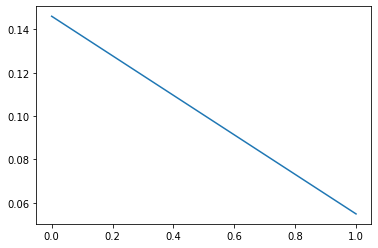

In [368]:
for k in range(epochs):
    localaccum = []
    for xy, conn, sda in iter(loader):
        i = i+1
        local_xy = Variable(xy)
        local_xy = local_xy.to(device)
        #print("local xy", local_xy)
        
        local_conn = Variable(conn)
        local_conn = local_conn.to(device)
        #print("local conn", local_conn)
        
        local_sda = Variable(sda)
        local_sda = local_sda.to(sda) 
        
        output = model.forward(local_xy,local_conn, debug=False)
        output = output.to(device)
        
        #ang = np.arccos(np.clip(output.cpu().detach().numpy(), -1.0, 1.0))
        #ang = torch.from_numpy(np.asarray(ang,dtype=np.float32))
        #ang = torch.acos(output)
        #msda = torch.std(ang)
        #print("ang msda, sda ",ang, msda, local_sda)
        print("output", (output), "sda", local_sda)
        loss = criterion(output, local_sda)
        #print("network loss -> ", loss)
        #print(local_xy, local_xyz)
        #if (i%500 == 0): print("network loss -> ", loss)
        optimizer.zero_grad()
        model.zero_grad()
        loss.backward()
        optimizer.step()
        localaccum.append(loss.item())
    train_accum.append(np.mean(localaccum))
plt.plot(train_accum);                      

In [352]:
print(list(model.parameters())[:])

[Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 1., -1.]]]), Parameter containing:
tensor([0., 0., 0.]), Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 1., -1.]]]), Parameter containing:
tensor([0., 0., 0.]), Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 1., -1.]]]), Parameter containing:
tensor([0., 0., 0.]), Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 1., -1.]

In [369]:
model.show_grad()

# 0 conv net grads:  None None
# 1 conv net grads:  None None
# 2 conv net grads:  None None
# 3 conv net grads:  None None
# 4 conv net grads:  None None
# 5 conv net grads:  None None
# 6 conv net grads:  None None
other grads:  tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]]) tensor([-0.0004, -0.0004, -0.0005, -0.0004, -0.0005, -0.0004, -0.0006, -0.0006])
other grads:  tensor([[-0.0003, -0.0003, -0.0004, -0.0003, -0.0004, -0.0003, -0.0004, -0.0004],
        [-0.0003, -0.0003, -0.0003, -0.0003, -0.0004, -0.0003, -0.0004, -0.0004],
        [-0.0003, -0.0003, -0.0003, -0.0003, -0.0003, -0.0003, -0.0003, -0.0003],
        [-0.0004, -0.0004, -0.0005, -0.0004, -0.0005, -0.0004, -0.0005, -0.0005],
        [

In [ ]:
# nverts = 8
# model = DepthEstNet(nverts, nonlinearity=fn.sigmoid, additional_hidden_wide=1)

## Compute SDA values for sample cube/cubiod objects

In [108]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def get_vector_between(v1, v2):
    return unit_vector(v2-v1)

In [169]:
#cuboid object
data = [[0.13454976677894592, 0.9894528388977051, -0.05366024002432823], [-0.9698463082313538, -0.1710100620985031, 0.1736481785774231], [-0.13454976677894592, -0.9894528388977051, 0.05366024002432823], [0.9698463082313538, 0.1710100620985031, -0.1736481785774231], [0.30555981397628784, 1.019606590270996, 0.9311475157737732], [-0.7988362312316895, -0.14085637032985687, 1.1584558486938477], [0.03646029531955719, -0.9592991471290588, 1.0384680032730103], [1.140856385231018, 0.20116375386714935, 0.8111595511436462]]
obj = np.asarray(data)
print(obj.shape)
print(obj)

(8, 3)
[[ 0.13454977  0.98945284 -0.05366024]
 [-0.96984631 -0.17101006  0.17364818]
 [-0.13454977 -0.98945284  0.05366024]
 [ 0.96984631  0.17101006 -0.17364818]
 [ 0.30555981  1.01960659  0.93114752]
 [-0.79883623 -0.14085637  1.15845585]
 [ 0.0364603  -0.95929915  1.038468  ]
 [ 1.14085639  0.20116375  0.81115955]]


## Create a corresponding connection matrix

In [178]:
# conn_raw = [[[1,1,1,0,1,1,1 #12,23,34,45,56,67,78             
#              ,0,0,0,0,0,0 #13,24,35,46,57,68
#              ,1,0,0,0,1 #14,25,36,47,58 
#              ,1,1,1,1 #15,26,37,48
#              ,0,0,0 #16,27,38
#              ,0,0 #17,28
#              ,0], #18
#   [1,1,1,0,0,1],
#   [1,1,1,0,0,1]]]

conn_raw = [[[1,1,1,0,1,1,1 #12,23,34,45,56,67,78             
             ,0,0,0,0,0,0 #13,24,35,46,57,68
             ,1,0,0,0,1 #14,25,36,47,58 
             ,1,1,1,1 #15,26,37,48
             ,0,0,0 #16,27,38
             ,0,0 #17,28
             ,0], #18
  [1,1,1,0,1,1,1 #12,23,34,45,56,67,78             
             ,0,0,0,0,0,0 #13,24,35,46,57,68
             ,1,0,0,0,1 #14,25,36,47,58 
             ,1,1,1,1 #15,26,37,48
             ,0,0,0 #16,27,38
             ,0,0 #17,28
             ,0], #18
 [1,1,1,0,1,1,1 #12,23,34,45,56,67,78             
             ,0,0,0,0,0,0 #13,24,35,46,57,68
             ,1,0,0,0,1 #14,25,36,47,58 
             ,1,1,1,1 #15,26,37,48
             ,0,0,0 #16,27,38
             ,0,0 #17,28
             ,0] #18
            ]]

conn = torch.from_numpy(np.asarray(conn_raw,dtype=np.float32))
print(conn.shape)

torch.Size([1, 3, 28])


In [179]:
# conn_raw = [[[1,1,1,0,1,1,1 ,0,0,0,0,0,0 ,1,0,0,0,1 ,1,1,1,1 ,0,0,0 ,0,0 ,0], #12,23,34,45,56,67,78, 13,24,35,46,57,68 14,25,36,47,58 15,26,37,48 16,27,38 17,28 18             
#               

In [180]:
nv = obj.shape[0]
obj_xyz = obj.T.reshape(1,3,nv)
print(obj_xyz)

[[[ 0.13454977 -0.96984631 -0.13454977  0.96984631  0.30555981
   -0.79883623  0.0364603   1.14085639]
  [ 0.98945284 -0.17101006 -0.98945284  0.17101006  1.01960659
   -0.14085637 -0.95929915  0.20116375]
  [-0.05366024  0.17364818  0.05366024 -0.17364818  0.93114752
    1.15845585  1.038468    0.81115955]]]


In [181]:
# x = obj_xyz[0,0,:]
# y = obj_xyz[0,1,:]
# z = obj_xyz[0,2,:]

# trace = go.Mesh3d(x=x,y=y,z=z,color='#FFB6C1',opacity=0.50)
# py.iplot([trace])

In [225]:
# conn represent which vertex is connected to which other vertex namely 1,2,..8
conn_vtx = [[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],
            [1,3],[2,4],[3,5],[4,6],[5,7],[6,8],
            [1,4],[2,5],[3,6],[4,7],[5,8],
            [1,5],[2,6],[3,7],[4,8],
            [1,6],[2,7],[3,8],
            [1,7],[2,8],
            [1,8]
           ]
angles_rad = []
angles_deg = []
norm_diff_vec = []
final_mat = []
ang_mat = []
for i,vi in enumerate(conn_vtx):
    dot_prod = []
    #print("conn mat: ", vi)
    a = vi[0]-1
    b = vi[1]-1
    v_ab = get_vector_between(obj[b], obj[a])
    norm_diff_vec.append(v_ab)
    angles_deg_row = []
    for j,vj in enumerate(conn_vtx):
        print("\n", vi,"->" , vj)
        c = vj[0]-1
        d = vj[1]-1
        v_cd = get_vector_between(obj[d], obj[c])
        angle_ikl = angle_between(v_ab, v_cd)
        #print(angle_ikl ," == ", np.degrees(angle_ikl))
        angles_rad.append(angle_ikl)
        angles_deg.append(np.degrees(angle_ikl))
        angles_deg_row.append(np.degrees(angle_ikl))
        #print(angles_rad)
        non_clipped = np.dot(v_ab, v_cd)
        clipped = np.clip(non_clipped, -0.99999, 0.99999)
        dot_prod.append(clipped)
        print("unit vec from a->b is ", v_ab,"\n" "c->d is ", v_cd, "\n", "angle is ", angle_ikl, 
              "\n", "dot prod is ", clipped, "\n", "arccos is ", np.arccos(clipped)) 
        #print("clipped = ", clipped, "non clipped = ", non_clipped )
    print("\n Dot prod: {}->{}".format(a+1,b+1), dot_prod)    
    final_mat.append(dot_prod)
    ang_mat.append(angles_deg_row)
print("\n final matrix: ", final_mat)    
print("sd of ang in rad: ", np.std(angles_rad))
print("sd of ang in deg: ", np.std(angles_deg))
# print(len(angles_rad))
print("angles in deg: ", np.around((ang_mat),2))
# print(np.asarray(norm_diff_vec).T)
# print(np.asarray(final_mat))
# print(np.std(np.arccos(final_mat)))


 [1, 2] -> [1, 2]
unit vec from a->b is  [ 0.68  0.72 -0.14] 
c->d is  [ 0.68  0.72 -0.14] 
 angle is  0.0 
 dot prod is  0.99999 
 arccos is  0.0044721396817777506

 [1, 2] -> [2, 3]
unit vec from a->b is  [ 0.68  0.72 -0.14] 
c->d is  [-0.71  0.7   0.1 ] 
 angle is  1.570796332761793 
 dot prod is  -5.966896476916617e-09 
 arccos is  1.570796332761793

 [1, 2] -> [3, 4]
unit vec from a->b is  [ 0.68  0.72 -0.14] 
c->d is  [-0.68 -0.72  0.14] 
 angle is  3.141592653589793 
 dot prod is  -0.99999 
 arccos is  3.1371205139080156

 [1, 2] -> [4, 5]
unit vec from a->b is  [ 0.68  0.72 -0.14] 
c->d is  [ 0.43 -0.55 -0.72] 
 angle is  1.5707963387120745 
 dot prod is  -1.1917177938913781e-08 
 arccos is  1.5707963387120745

 [1, 2] -> [5, 6]
unit vec from a->b is  [ 0.68  0.72 -0.14] 
c->d is  [ 0.68  0.72 -0.14] 
 angle is  6.495265578539184e-08 
 dot prod is  0.99999 
 arccos is  0.0044721396817777506

 [1, 2] -> [6, 7]
unit vec from a->b is  [ 0.68  0.72 -0.14] 
c->d is  [-0.71  0.7   0

c->d is  [ 0.04  0.87 -0.49] 
 angle is  0.4636476158929686 
 dot prod is  0.894427187917647 
 arccos is  0.4636476158929689

 [1, 3] -> [2, 8]
unit vec from a->b is  [ 0.13  0.99 -0.05] 
c->d is  [-0.94 -0.17 -0.29] 
 angle is  1.8508354025267288 
 dot prod is  -0.27639320229770187 
 arccos is  1.8508354025267286

 [1, 3] -> [1, 8]
unit vec from a->b is  [ 0.13  0.99 -0.05] 
c->d is  [-0.65  0.51 -0.56] 
 angle is  1.106590427294785 
 dot prod is  0.44771287598145665 
 arccos is  1.106590427294785

 Dot prod: 1->3 [0.8090169927111656, 0.5877852497551518, -0.8090169927111656, -0.447712897593158, 0.8090170186554692, 0.5877852657586696, -0.8090169876217179, 0.99999, -0.30901699291206475, -0.8944271943067102, 0.2763932045768463, 0.99999, -0.3090169929120645, 0.5877852497551518, -0.6881909792002209, -0.4477128959781591, 0.6881909539027009, 0.5877852626543701, -5.631303161279799e-08, -5.9446415429098565e-09, 1.0578060510857412e-09, -2.746241539730576e-09, 0.6881909743392628, 0.4477128758147

unit vec from a->b is  [ 0.49  0.59 -0.64] 
c->d is  [-0.71  0.7   0.1 ] 
 angle is  1.5707963368708167 
 dot prod is  -1.0075920056640264e-08 
 arccos is  1.5707963368708167

 [4, 7] -> [3, 4]
unit vec from a->b is  [ 0.49  0.59 -0.64] 
c->d is  [-0.68 -0.72  0.14] 
 angle is  2.588018290040876 
 dot prod is  -0.8506508059064062 
 arccos is  2.588018290040876

 [4, 7] -> [4, 5]
unit vec from a->b is  [ 0.49  0.59 -0.64] 
c->d is  [ 0.43 -0.55 -0.72] 
 angle is  1.2231986036709481 
 dot prod is  0.3406401868599998 
 arccos is  1.2231986036709481

 [4, 7] -> [5, 6]
unit vec from a->b is  [ 0.49  0.59 -0.64] 
c->d is  [ 0.68  0.72 -0.14] 
 angle is  0.5535744136595986 
 dot prod is  0.8506507795616606 
 arccos is  0.5535744136595986

 [4, 7] -> [6, 7]
unit vec from a->b is  [ 0.49  0.59 -0.64] 
c->d is  [-0.71  0.7   0.1 ] 
 angle is  1.5707962801660762 
 dot prod is  4.662882034656146e-08 
 arccos is  1.5707962801660762

 [4, 7] -> [7, 8]
unit vec from a->b is  [ 0.49  0.59 -0.64] 
c->d

c->d is  [-0.67 -0.63 -0.4 ] 
 angle is  1.2231985891862205 
 dot prod is  0.3406402004784498 
 arccos is  1.2231985891862205

 [2, 7] -> [1, 7]
unit vec from a->b is  [-0.65  0.51 -0.56] 
c->d is  [ 0.04  0.87 -0.49] 
 angle is  0.8090137385900306 
 dot prod is  0.6902124339842328 
 arccos is  0.8090137385900306

 [2, 7] -> [2, 8]
unit vec from a->b is  [-0.65  0.51 -0.56] 
c->d is  [-0.94 -0.17 -0.29] 
 angle is  0.8090137469352121 
 dot prod is  0.6902124279456028 
 arccos is  0.8090137469352121

 [2, 7] -> [1, 8]
unit vec from a->b is  [-0.65  0.51 -0.56] 
c->d is  [-0.65  0.51 -0.56] 
 angle is  2.1073424255447017e-08 
 dot prod is  0.99999 
 arccos is  0.0044721396817777506

 Dot prod: 2->7 [7.795219608697224e-10, 0.7616946354024283, -7.795219608697224e-10, -0.16035746829265446, 1.931507342955996e-09, 0.7616946845495419, -6.3858568988273134e-09, 0.4477128758147663, 0.4477128720127675, -0.11068072017099853, -0.11068072280869456, 0.44771288513920393, 0.44771289102940776, 0.76169463

In [321]:
out = model.forward(torch.Tensor(obj_xyz),conn,debug=True)

initial xyz tensor([[[ 0.1345, -0.9698, -0.1345,  0.9698,  0.3056, -0.7988,  0.0365,
           1.1409],
         [ 0.9895, -0.1710, -0.9895,  0.1710,  1.0196, -0.1409, -0.9593,
           0.2012],
         [-0.0537,  0.1736,  0.0537, -0.1736,  0.9311,  1.1585,  1.0385,
           0.8112]]])
initial z tensor([[-0.0537,  0.1736,  0.0537, -0.1736,  0.9311,  1.1585,  1.0385,  0.8112]])
new xyz tensor([[[  0.1345,  -0.9698,  -0.1345,   0.9698,   0.3056,  -0.7988,   0.0365,
            1.1409],
         [  0.9895,  -0.1710,  -0.9895,   0.1710,   1.0196,  -0.1409,  -0.9593,
            0.2012],
         [-28.5769, -19.4283, -10.5113,  -2.6184,   2.3682,  10.7766,  20.0899,
           27.6236]]], grad_fn=<UnsqueezeBackward0>)
Conv output:  tensor([[[ 1.1044e+00, -8.3530e-01, -1.1044e+00,  6.6429e-01,  1.1044e+00,
          -8.3530e-01, -1.1044e+00,  2.6910e-01, -1.9397e+00, -4.4011e-01,
           1.7687e+00,  2.6910e-01, -1.9397e+00, -8.3530e-01, -1.2754e+00,
           6.6429e-01,  9.3339e-

In [1452]:
ang = np.arccos(np.clip(out.detach().numpy(), -1.0, 1.0))
#ang = np.degrees(ang)
#np.std(out.detach().numpy())
np.std(ang)

0.0

In [1453]:
out

tensor(0.0332, grad_fn=<StdBackward0>)

In [1454]:
torch.std(out)

tensor(nan, grad_fn=<StdBackward0>)

In [1455]:
torch.mean(out)

tensor(0.0332, grad_fn=<MeanBackward0>)

## Test Inversion

In [370]:
model.inversion(torch.Tensor(obj_xyz),conn,debug=False)

network output:  tensor(0.1069, grad_fn=<StdBackward0>)
tensor([[ 2.7463e-05, -8.8873e-05, -2.7463e-05,  8.8873e-05, -4.7656e-04,
         -5.9290e-04, -5.3149e-04, -4.1515e-04],
        [ 2.2075e-05, -7.1435e-05, -2.2075e-05,  7.1435e-05, -3.8305e-04,
         -4.7656e-04, -4.2720e-04, -3.3369e-04],
        [ 3.5238e-05, -1.1403e-04, -3.5238e-05,  1.1403e-04, -6.1148e-04,
         -7.6075e-04, -6.8196e-04, -5.3268e-04],
        [ 2.4298e-05, -7.8631e-05, -2.4298e-05,  7.8631e-05, -4.2164e-04,
         -5.2457e-04, -4.7024e-04, -3.6731e-04],
        [ 3.6088e-05, -1.1678e-04, -3.6088e-05,  1.1678e-04, -6.2622e-04,
         -7.7909e-04, -6.9840e-04, -5.4553e-04],
        [ 2.0616e-05, -6.6714e-05, -2.0616e-05,  6.6714e-05, -3.5774e-04,
         -4.4507e-04, -3.9897e-04, -3.1164e-04],
        [ 3.4941e-05, -1.1307e-04, -3.4941e-05,  1.1307e-04, -6.0631e-04,
         -7.5433e-04, -6.7620e-04, -5.2818e-04],
        [ 3.3967e-05, -1.0992e-04, -3.3967e-05,  1.0992e-04, -5.8941e-04,
         

## Test Spurious Conn Approx Fix


In [239]:
N = 8
mat_row = []
for r in range(N-1,0,-1):
    mats = []
    for n in range(r,0,-1):
        #print("n = ",n)
        f = np.ones((n,n), dtype=int)
        for i in range(1,n):
            f[-i-2::-1,-i] = 0 
        f = f.T&f
        mat = np.copy(f)
        pad = r-n
        for j in range(pad,0,-1):
            if (j>n):
                p = np.zeros((1,n), dtype=int)
            else:
                p = f[:,-j]
            mat = np.vstack((mat,p))   
        #print("mat shape: ", mat.shape)
        mats.append(mat)

    mats=np.hstack(mats)
    
    #print(mats)
    
    pad = int(N*(N-1)/2) - mats.shape[1] 
    m = nn.ZeroPad2d((pad, 0, 0, 0)) #padding(left,right,top,bottom)
    
    mats = torch.from_numpy(mats)
    mat_row.append(m(mats))
    print(m(mats).shape)

mat_row = torch.cat(mat_row)    
print(mat_row)    

torch.Size([7, 28])
torch.Size([6, 28])
torch.Size([5, 28])
torch.Size([4, 28])
torch.Size([3, 28])
torch.Size([2, 28])
torch.Size([1, 28])
tensor([[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
         0, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
         1, 1, 1, 0],
        [0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
         1, 0, 0, 0],
        [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
         0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
         1, 1, 1, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
         1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
         0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 

In [130]:
mats

tensor([[1]])

In [240]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model.to(device)
msda = []
l2_norm = []
n = train_xy_obj.shape[0]
for i in range(10):
    print(i)
    print("****************************************************")
    obj = torch.Tensor(train_xy_obj[i].unsqueeze(0)).to(device)
    conn = torch.Tensor(train_xy_conn[i].unsqueeze(0)).to(device)
    output = model.forward(obj, conn, extract_z=True)
    print("Obj:", obj)
    print("Obj:", obj.shape)
    print("Conn:", conn)
    print("Conn:", conn.shape)
    print("Output:", output)
    #print("Z matrix shape:", output.shape)
    #print("Z coords:", output)
    #msda.append((output.std()))  
#     if (i == 0):
#         origin = output
#         #print(origin)
#     else:    
#         l2_norm.append(torch.norm(origin - output))
print(msda)        

AttributeError: 'list' object has no attribute 'shape'

## Test by reconstruction

In [323]:
i=2

In [324]:
obj = objs[i]

x = obj[0]
y = obj[1]
z = obj[2]

trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgb(204, 204, 204)',
            width=0.5
        ),
        opacity=0.8
    )
)

data = [trace]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')



In [326]:
obj = objs[i]

x = obj[0]
y = obj[1]
z = obj[2]

x_recovered, y_recovered, z_recovered = model.forward(torch.Tensor(train_xyz_obj[i].unsqueeze(0)).to(device), 
              torch.Tensor(train_xy_conn[i].unsqueeze(0)).to(device), extract_z=True, debug=True)
    
x=x_recovered.detach().tolist()[0]
y=y_recovered.detach().tolist()[0]
z=z_recovered.detach().tolist()[0]
    
    
trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgb(204, 204, 204)',
            width=0.5
        ),
        opacity=0.8
    )
)

data = [trace]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')



initial xyz tensor([[[ 0.8101,  0.8043,  0.7816,  0.8569, -0.7791, -0.7889, -0.8131,
           0.0000],
         [ 0.9744, -0.9960,  1.0007, -0.9749, -1.0355,  1.0415, -0.9838,
           0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000]]])
initial z tensor([[0., 0., 0., 0., 0., 0., 0., 0.]])
new xyz tensor([[[  0.8101,   0.8043,   0.7816,   0.8569,  -0.7791,  -0.7889,  -0.8131,
            0.0000],
         [  0.9744,  -0.9960,   1.0007,  -0.9749,  -1.0355,   1.0415,  -0.9838,
            0.0000],
         [-28.6900, -19.5039, -10.5346,  -2.6392,   2.3656,  10.8273,  20.1705,
           27.7368]]], grad_fn=<UnsqueezeBackward0>)
Conv output:  tensor([[[ 5.7536e-03,  2.2734e-02, -7.5310e-02,  1.6360e+00,  9.8361e-03,
           2.4195e-02, -8.1312e-01,  2.8487e-02, -5.2577e-02,  1.5607e+00,
           1.6458e+00,  3.4031e-02, -7.8892e-01, -4.6823e-02,  1.5834e+00,
           1.5705e+00,  1.6700e+00, -7.7909e-01,  1.5892e+00,  1.5933e+0

In [1505]:
import plotly.graph_objs as go

def plot_obj(i,objs):
    obj = objs[i]

    x = obj[0]
    y = obj[1]
    z = obj[2]

    print(x,y,z)

    # trace = go.Mesh3d(x=x,y=y,z=z,color='#0066FF',opacity=0.80)
    # py.iplot([trace])

    trace = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=12,
            line=dict(
                color='rgb(204, 204, 204)',
                width=0.5
            ),
            opacity=0.8
        )
    )

    data = [trace]
    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='simple-3d-scatter')
    
    
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
    
def test_reconstruct(N, objs):
    print(N)
    print("******************************")
    fig = plt.figure()
    ax = Axes3D(fig)

    test_obj=objs[N]



    print("_________ORIG________")

    x=test_obj[0]
    y=test_obj[1]
    z=test_obj[2]

    verts = [list(zip(x, y,z))]
    print(verts)
    #ax.add_collection3d(Poly3DCollection(verts))
    ax.scatter(x, y, z, c='b', marker='o')
    #lt.show()

    
    print("_________RECONST________")

    x_recovered, y_recovered, z_recovered = model.forward(torch.Tensor(train_xyz_obj[i].unsqueeze(0)).to(device), 
              torch.Tensor(train_xy_conn[i].unsqueeze(0)).to(device), extract_z=True)
    
    x=x_recovered.detach().tolist()[0]
    y=y_recovered.detach().tolist()[0]
    z=z_recovered.detach().tolist()[0]

    verts = [list(zip(x, y,z))]
    print(verts)
    #ax.add_collection3d(Poly3DCollection(verts))
    ax.scatter(x, y, z, c='r', marker='o')
    plt.show()
    
    

1
******************************
_________ORIG________
[[(0.7357309460639954, 0.979057788848877, -0.7663657665252686), (0.7305053472518921, -1.0007728338241577, -0.8376749753952026), (0.7098585367202759, 1.0054240226745605, 0.7361288070678711), (0.778256356716156, -0.9795495867729187, 0.8183904886245728), (-0.7075781226158142, -1.0404164791107178, -0.7927998304367065), (-0.7165113687515259, 1.0464118719100952, 0.7812433838844299), (-0.73848557472229, -0.9884710907936096, 0.7782409191131592)]]
_________RECONST________
[[(0.7091562747955322, 0.45165756344795227, -0.5159934163093567), (0.7438804507255554, 0.7329924702644348, 1.1885387897491455), (0.7211530804634094, 0.507182240486145, 2.6391191482543945), (0.7616884112358093, -0.563785195350647, -1.9438837766647339), (-0.7053310871124268, -0.052126992493867874, 2.020890474319458), (-0.7216148972511292, -0.5102074146270752, -0.688231348991394), (-0.7538034915924072, -0.03737351670861244, 0.37119221687316895), (-0.015328340232372284, 0.0473

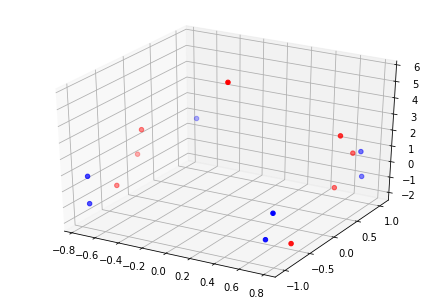

2
******************************
_________ORIG________
[[(0.8100869655609131, 0.9744318127632141, -0.8263795971870422), (0.8043333292007446, -0.9960437417030334, -0.9032723903656006), (0.7815998196601868, 1.0006730556488037, 0.7937742471694946), (0.856910228729248, -0.9749213457107544, 0.8824783563613892), (-0.7790889143943787, -1.035500168800354, -0.8548831343650818), (-0.7889249920845032, 1.0414671897888184, 0.8424216508865356), (-0.8131200671195984, -0.9838007092475891, 0.8391847014427185)]]
_________RECONST________
[[(0.8342768549919128, 0.46052682399749756, -0.5308156609535217), (0.791858434677124, 0.7239203453063965, 1.2254654169082642), (0.7712138891220093, 0.500069260597229, 2.7224879264831543), (0.8719741702079773, -0.5542609691619873, -1.992733120918274), (-0.781020998954773, -0.05278780311346054, 2.096564292907715), (-0.784159243106842, -0.5056627988815308, -0.7082254886627197), (-0.7989586591720581, -0.03081449121236801, 0.3813888728618622), (0.0140080526471138, 0.053501009

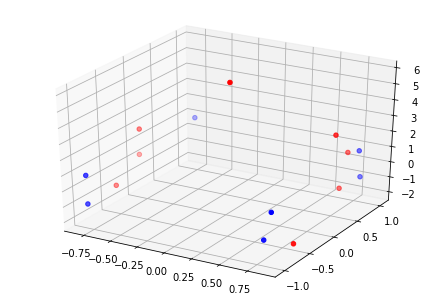

3
******************************
_________ORIG________
[[(0.14912953972816467, 0.3560808598995209, -0.48021262884140015), (0.1480703502893448, -0.3639770448207855, -0.5248937606811523), (0.1438853144645691, 0.36566877365112305, 0.4612639546394348), (0.1577492654323578, -0.3562597930431366, 0.5128117799758911), (-0.14342308044433594, -0.3783954083919525, -0.4967745244503021), (-0.14523380994796753, 0.38057592511177063, 0.48953312635421753), (-0.14968790113925934, -0.35950449109077454, 0.4876537024974823)]]
_________RECONST________
[[(0.1534663438796997, 0.16819466650485992, -0.41675737500190735), (0.14584219455718994, 0.2645912766456604, 0.9986913204193115), (0.14202256500720978, 0.18277566134929657, 2.2303733825683594), (0.16044935584068298, -0.202598437666893, -1.6933242082595825), (-0.1437768191099167, -0.019288543611764908, 1.6575613021850586), (-0.14438283443450928, -0.18480202555656433, -0.5873022079467773), (-0.14715665578842163, -0.011320505291223526, 0.33912938833236694), (0.00

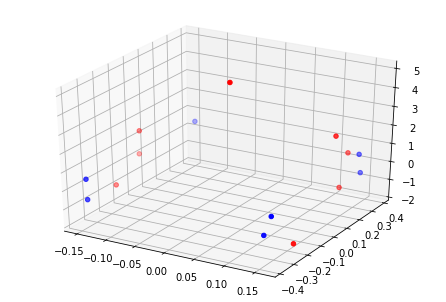

4
******************************
_________ORIG________
[[(0.8735414147377014, 0.6521538496017456, -0.8981115221977234), (0.8673370480537415, -0.6666153073310852, -0.9816757440567017), (0.842822790145874, 0.6697137355804443, 0.8626730442047119), (0.9240323305130005, -0.6524815559387207, 0.9590796828269958), (-0.8401152491569519, -0.6930222511291504, -0.9290861487388611), (-0.8507217764854431, 0.6970157623291016, 0.9155430197715759), (-0.8768120408058167, -0.6584240794181824, 0.9120281338691711)]]
_________RECONST________
[[(0.846450924873352, 0.30109184980392456, -0.5596979260444641), (0.8811976313591003, 0.48816874623298645, 1.2750370502471924), (0.8544031381607056, 0.33774563670158386, 2.826547145843506), (0.9071515798568726, -0.37538793683052063, -2.0580122470855713), (-0.8378908634185791, -0.034758612513542175, 2.187974214553833), (-0.855997622013092, -0.3398178219795227, -0.7343284487724304), (-0.8925846815109253, -0.02478451281785965, 0.38706931471824646), (-0.015650808811187744, 

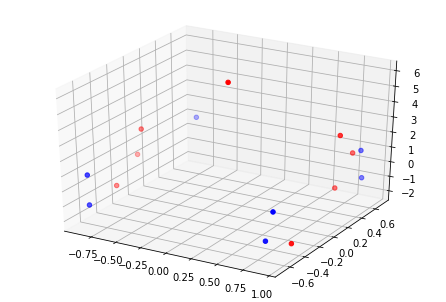

5
******************************
_________ORIG________
[[(0.9323145151138306, 0.016078101471066475, -0.030132709071040154), (0.9256927371025085, -0.016434570774435997, -0.03293634206056595), (0.8995291590690613, 0.016510963439941406, 0.028943661600351334), (0.9862025380134583, -0.016086183488368988, 0.03217826038599014), (-0.8960255980491638, 0.01678621396422386, -0.02918456308543682), (-0.8966394066810608, -0.0170856025069952, -0.031171899288892746), (-0.9079595804214478, 0.0171840600669384, 0.030717510730028152), (-0.9358052611351013, -0.0162326879799366, 0.030599625781178474)]]
_________RECONST________
[[(0.9907093644142151, 0.0007494017481803894, -0.31039249897003174), (0.8955610394477844, 1.7352402210235596e-05, 0.7236607670783997), (0.8743758797645569, -0.0034763822332024574, 1.6070873737335205), (1.0225180387496948, -0.019372202455997467, -1.3266907930374146), (-0.9006894826889038, -0.0020510517060756683, 1.0904757976531982), (-0.8850939869880676, 0.001566404476761818, -0.437345

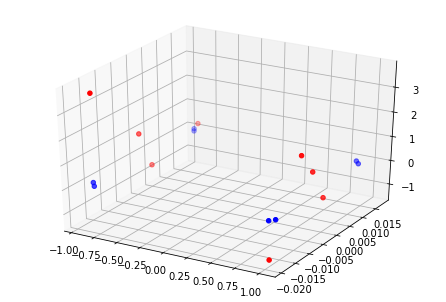

6
******************************
_________ORIG________
[[(0.9382349252700806, 0.7650790214538574, -0.8661271333694458), (0.9315710663795471, -0.7820460796356201, -0.94671630859375), (0.9052413702011108, 0.7856808304786682, 0.8319516181945801), (0.9924651384353638, -0.7654634118080139, 0.9249240756034851), (-0.9023332595825195, -0.8130254745483398, -0.8959996104240417), (-0.9137253165245056, 0.8177105188369751, 0.882938802242279), (-0.941747784614563, -0.7724350094795227, 0.8795480728149414)]]
_________RECONST________
[[(0.8664807081222534, 0.34568434953689575, -0.6210853457450867), (0.9681351780891418, 0.5765523314476013, 1.2908170223236084), (0.9358209371566772, 0.399454802274704, 2.811631917953491), (0.9477345943450928, -0.44508999586105347, -2.075037956237793), (-0.8963690996170044, -0.04015248268842697, 2.153269052505493), (-0.9276152849197388, -0.40012460947036743, -0.737330436706543), (-0.9834020733833313, -0.03346091881394386, 0.3410940170288086), (-0.04089125990867615, 0.032866

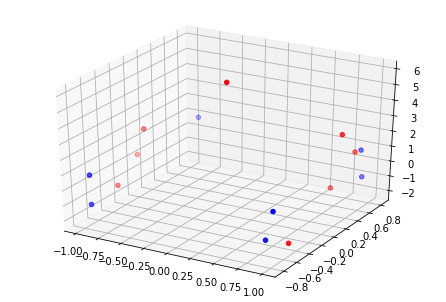

7
******************************
_________ORIG________
[[(0.9759292602539062, 0.5674376487731934, -0.9607089161872864), (0.9689976572990417, -0.5800191760063171, -1.0500965118408203), (0.9416101574897766, 0.5827152132987976, 0.9227994084358215), (1.0323381423950195, -0.5677228569984436, 1.0259264707565308), (-0.9385852217674255, -0.6029958128929138, -0.9938414692878723), (-0.9504349827766418, 0.6064705848693848, 0.9793543815612793), (-0.9795832633972168, -0.5728934407234192, 0.9755954742431641)]]
_________RECONST________
[[(1.0972455739974976, 0.27586549520492554, -0.641918957233429), (0.9058767557144165, 0.4175302982330322, 1.3478702306747437), (0.8889942765235901, 0.2878239154815674, 2.942188024520874), (1.1077039241790771, -0.3179808557033539, -2.1504926681518555), (-0.947998583316803, -0.03133465349674225, 2.272294759750366), (-0.9261860251426697, -0.2929255962371826, -0.7683239579200745), (-0.9080203175544739, -0.013409115374088287, 0.3586650490760803), (0.06908228248357773, 0.035

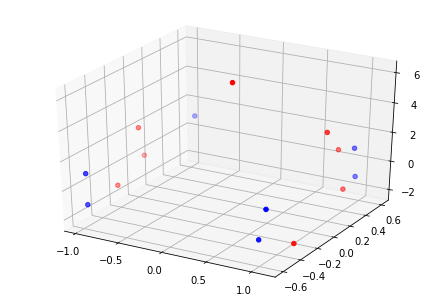

8
******************************
_________ORIG________
[[(0.08020590990781784, 0.9889488816261292, -0.877553403377533), (0.07963624596595764, -1.0108824968338013, -0.9592074751853943), (0.07738541811704636, 1.0155807733535767, 0.8429286479949951), (0.08484182506799698, -0.989445686340332, 0.937126100063324), (-0.0771368220448494, -1.050926685333252, -0.9078217148780823), (-0.07811067998409271, 1.0569827556610107, 0.8945885300636292), (-0.08050621300935745, -0.9984573721885681, 0.8911514282226562)]]
_________RECONST________
[[(0.08989927172660828, 0.478780597448349, -0.6136276125907898), (0.07458306103944778, 0.7287190556526184, 1.2929209470748901), (0.07315562665462494, 0.5025056600570679, 2.8235738277435303), (0.09086532890796661, -0.5554394721984863, -2.078014850616455), (-0.0778922587633133, -0.054439809173345566, 2.166773796081543), (-0.07617561519145966, -0.5109087228775024, -0.7390982508659363), (-0.07479339838027954, -0.02453266829252243, 0.3490419089794159), (0.0055310800671577

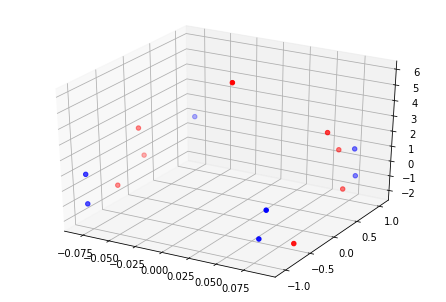

9
******************************
_________ORIG________
[[(0.9054247736930847, 0.2759987711906433, -0.16728754341602325), (0.898993968963623, -0.2821206748485565, -0.18285389244556427), (0.8735849857330322, 0.28343185782432556, 0.160687655210495), (0.9577585458755493, -0.27613744139671326, 0.1786438673734665), (-0.8707786202430725, -0.29329636693000793, -0.17305821180343628), (-0.8817722797393799, 0.29498645663261414, 0.1705355942249298), (-0.9088147878646851, -0.27865245938301086, 0.1698797196149826)]]
_________RECONST________
[[(0.7643067240715027, 0.11801999807357788, -0.37486815452575684), (0.9700677990913391, 0.21140286326408386, 0.8248758912086487), (0.933009922504425, 0.14695461094379425, 1.8113822937011719), (0.869535505771637, -0.16474568843841553, -1.4606688022613525), (-0.8586112260818481, -0.013927694410085678, 1.2656993865966797), (-0.9083478450775146, -0.145612433552742, -0.49008116126060486), (-0.9898197054862976, -0.015929318964481354, 0.26509028673171997), (-0.079363837

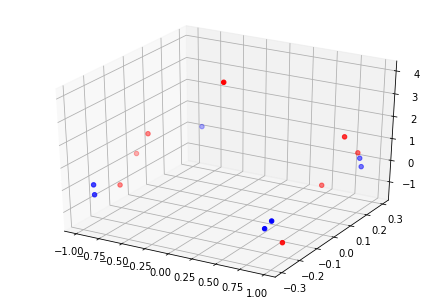

In [1506]:
for i in range(1,10):
    test_reconstruct(i,objs)

In [1460]:
for i in range(1,10):
    plot_obj(i,objs)

[ 0.73573095  0.73050535  0.70985854  0.77825636 -0.70757812 -0.71651137
 -0.73848557] [ 0.97905779 -1.00077283  1.00542402 -0.97954959 -1.04041648  1.04641187
 -0.98847109] [-0.76636577 -0.83767498  0.73612881  0.81839049 -0.79279983  0.78124338
  0.77824092]
[ 0.81008697  0.80433333  0.78159982  0.85691023 -0.77908891 -0.78892499
 -0.81312007] [ 0.97443181 -0.99604374  1.00067306 -0.97492135 -1.03550017  1.04146719
 -0.98380071] [-0.8263796  -0.90327239  0.79377425  0.88247836 -0.85488313  0.84242165
  0.8391847 ]
[ 0.14912954  0.14807035  0.14388531  0.15774927 -0.14342308 -0.14523381
 -0.1496879 ] [ 0.35608086 -0.36397704  0.36566877 -0.35625979 -0.37839541  0.38057593
 -0.35950449] [-0.48021263 -0.52489376  0.46126395  0.51281178 -0.49677452  0.48953313
  0.4876537 ]
[ 0.87354141  0.86733705  0.84282279  0.92403233 -0.84011525 -0.85072178
 -0.87681204] [ 0.65215385 -0.66661531  0.66971374 -0.65248156 -0.69302225  0.69701576
 -0.65842408] [-0.89811152 -0.98167574  0.86267304  0.959

In [1483]:
i=5
x_recovered, y_recovered, z_recovered = model.forward(torch.Tensor(train_xyz_obj[i].unsqueeze(0)).to(device), 
              torch.Tensor(train_xy_conn[i].unsqueeze(0)).to(device), extract_z=True)
z = z_recovered.cpu().detach().tolist()[0]
#y = y_recovered.cpu().detach().tolist()[0]
#x = x_recovered.cpu().detach().tolist()[0]

print(x,"\n\n",y,"\n\n",z)

# trace = go.Mesh3d(x=x,y=y,z=z,color='#0066FF',opacity=0.80)
# py.iplot([trace])

trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgb(204, 204, 204)',
            width=0.5
        ),
        opacity=0.8
    )
)

data = [trace]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

tensor([[[ 0.9778,  0.9709,  0.9434,  1.0343, -0.9404, -0.9523, -0.9815,
           0.0000],
         [ 0.9533, -0.9745,  0.9790, -0.9538, -1.0131,  1.0189, -0.9625,
           0.0000],
         [-0.2029, -0.2218,  0.1949,  0.2167, -0.2099,  0.2069,  0.2061,
           0.0000]]]) 

 [ 0.6421333  -0.65637755  0.65942806 -0.64245582 -0.68237865  0.68631083
 -0.6483072 ] 

 [-0.2827427387237549, 0.7096775770187378, 1.5953646898269653, -1.3098256587982178, 1.0879499912261963, -0.4317934513092041, 0.272436261177063, 3.6846680641174316]


In [ ]:
 [-0.23599386 -0.2579518   0.22668184  0.25201425 -0.24413301  0.24057432
  0.23965067]
 [0.1274, 0.1235, 0.1364, -0.0264, -0.121, -0.393, 0.0617, 0.0404]

TEST BY RENDERING

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt


    
def test_reconstruct(N):
    print(N)
    print("******************************")
    fig = plt.figure()
    ax = Axes3D(fig)

    test_obj=test_xyz[N,:,:]
    d,t = test_obj.size()
    obj,conn = torch.Tensor.split(test_obj,[8,t-8],dim=1)
    #print(obj)
    #print(conn)
    fullobj = np.concatenate((obj,conn), axis=1)
    computed_z = model.forward(torch.Tensor([fullobj]).to(device), extract_z=True)
    orig_z = obj[2]


    print("_________ORIG________")

    x=obj[0]
    y=obj[1]
    z=obj[2]


    x=[(i-min(x))/(max(x)-min(x)) for i in x]
    y=[(i-min(y))/(max(y)-min(y)) for i in y]
    z=[(i-min(z))/(max(z)-min(z)) for i in z]

    verts = [list(zip(x, y,z))]
    #ax.add_collection3d(Poly3DCollection(verts))
    ax.scatter(x, y, z, c='r', marker='o')
    plt.show()


    print("_________RECON________")

    fig = plt.figure()
    ax = Axes3D(fig)
    x=obj[0]
    y=obj[1]
    z=computed_z.to('cpu').detach().numpy()[0]
    #print("Test  obj's   z: ", obj[2])
    #print("Model computed z:", z)

    x=[(i-min(x))/(max(x)-min(x)) for i in x]
    y=[(i-min(y))/(max(y)-min(y)) for i in y]
    z=[(i-min(z))/(max(z)-min(z)) for i in z]

    verts = [list(zip(x, y,z))]
    #ax.add_collection3d(Poly3DCollection(verts))
    ax.scatter(x, y, z, c='r', marker='o')
    plt.show()



In [ ]:
N=[15,]

In [ ]:
for i in range(50,60):
    test_reconstruct(i)

In [ ]:
trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgb(204, 204, 204)',
            width=0.5
        ),
        opacity=0.8
    )
)

data = [trace]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

Test Performance

In [ ]:
import torch.utils.data
dataset = torch.utils.data.TensorDataset(test_xy[:,:,:], test_xyz[:,:,:])
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)
model.to(device)
criterion = nn.L1Loss()
lr, epochs, batch_size = 1e-1 , 1 , 1
optimizer = torch.optim.SGD(model.parameters(), lr = lr )
accum=[]
i = 0
for k in range(epochs):
    localaccum = []
    for xy, xyz in iter(loader):
        i =  i+1
        local_xy = Variable(xy)
        #print(local_xy)
        local_xyz = Variable(xyz)
        local_xy = local_xy.to(device)
        local_xyz = local_xyz.to(device)
        output = model.forward(local_xy)
        output = output.to(device)
        #print("output:",output)
        #print("actual:", local_xyz[:,2,0:8])
        #loss = criterion(output, local_xyz[:,2,0:8])
        loss = criterion(output, torch.Tensor.new_zeros(output, output.size()))
        
        #print(local_xy, local_xyz)
        #if (i%100 == 0): print("network loss -> ", loss)
        #model.zero_grad()
        #loss.backward()
        #optimizer.step()
        localaccum.append(loss.data[0])
    accum.append(np.mean(localaccum))
plt.plot(localaccum);                                           

In [ ]:
plt.ylabel('SDA')
plt.xlabel('Objects')
plt.ylim((0.06,0.08))
plt.plot(localaccum[0:1000])